# Memoria M0_2 b) Identificar Rotación

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
import matplotlib
from PIL import Image
import keras

Using TensorFlow backend.


## Load csv data

In [2]:
# Read csv file
df = pd.read_csv('./REY_DATASET/traza_REY.csv', sep='; ',header=None)
df.columns = ['id','fname','forig','BB','rot']
df.head()

/home/irene/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


id                                  fname  \
0  id:0   fname:ROI_0_Psic_012Ev1.pdf_pg-7.png   
1  id:1  fname:ROI_0_Psic_502Ev2.pdf_pg-23.png   
2  id:3  fname:ROI_0_Psic_202Ev5.pdf_pg-29.png   
3  id:4  fname:ROI_0_Psic_237Ev4.pdf_pg-24.png   
4  id:5  fname:ROI_0_Psic_421Ev1.pdf_pg-36.png   

                             forig                       BB     rot  
0   forig:Psic_012Ev1.pdf_pg-7.jpg  BB:[187, 221, 200, 182]   rot:0  
1  forig:Psic_502Ev2.pdf_pg-23.jpg  BB:[209, 349, 360, 250]  rot:90  
2  forig:Psic_202Ev5.pdf_pg-29.jpg   BB:[37, 211, 419, 548]   rot:0  
3  forig:Psic_237Ev4.pdf_pg-24.jpg   BB:[61, 197, 371, 434]   rot:0  
4  forig:Psic_421Ev1.pdf_pg-36.jpg  BB:[120, 204, 439, 306]  rot:90

In [3]:
for its in df.columns:
    df[its] = df[its].map(lambda x: x.lstrip(its+':'))
df.head()

id                            fname                      forig  \
0  0   ROI_0_Psic_012Ev1.pdf_pg-7.png   Psic_012Ev1.pdf_pg-7.jpg   
1  1  ROI_0_Psic_502Ev2.pdf_pg-23.png  Psic_502Ev2.pdf_pg-23.jpg   
2  3  ROI_0_Psic_202Ev5.pdf_pg-29.png  Psic_202Ev5.pdf_pg-29.jpg   
3  4  ROI_0_Psic_237Ev4.pdf_pg-24.png  Psic_237Ev4.pdf_pg-24.jpg   
4  5  ROI_0_Psic_421Ev1.pdf_pg-36.png  Psic_421Ev1.pdf_pg-36.jpg   

                     BB rot  
0  [187, 221, 200, 182]   0  
1  [209, 349, 360, 250]  90  
2   [37, 211, 419, 548]   0  
3   [61, 197, 371, 434]   0  
4  [120, 204, 439, 306]  90

### Class balances

In [4]:
df.groupby('rot')['id'].count() # see the balance of clases

rot
         1
-90    104
0      319
180     30
90     435
Name: id, dtype: int64

In [5]:
df_0 = df.loc[df['rot']=='0']
df_1 = df.loc[df['rot']=='90']
df_2 = df.loc[df['rot']=='180']
df_3 = df.loc[df['rot']=='-90']
df_0.shape,df_1.shape,df_2.shape,df_3.shape

((319, 5), (435, 5), (30, 5), (104, 5))

## Load images

In [6]:
img_h, img_w = 600, 600
reduct = 0.5
redim_vec = [it*reduct for it in [img_w,img_h,img_h,img_w]]

### Data augmentation

In [57]:
from keras.preprocessing.image import ImageDataGenerator
def fit_augmentation(img,gen,batch):
    gen.fit(img)
    image_iterator = gen.flow(img, batch_size=batch)
    aas = []
    for i in range(batch):
        aas.append(image_iterator.next()[0].astype('int'))
    return aas

def data_augmentation(images,batch):
    IDG = [ImageDataGenerator(width_shift_range=[-0.3,0]),ImageDataGenerator(height_shift_range=[-0.3,0.]),ImageDataGenerator(zoom_range=[0.8, 1.2])]
    final_imgs = []
    for data_generator in IDG:
        for img_ in fit_augmentation(images, data_generator, batch):
            final_imgs.append(img_)

    return final_imgs

### Preprocessing

In [8]:
# add white pixels to fit all images into the same size
def adjust_dims(img,b,r):
    size = img.shape[:2]
    color = [255,255,255]
    bottom = b-size[0]
    right = r-size[1]
    out_img = cv2.copyMakeBorder(img, 0,bottom,0,right,cv2.BORDER_CONSTANT,value=color)
    return out_img

# reduce images size
from skimage.transform import rescale, resize
def reduce_imgs(img, reduct):
    img = resize(img, (img.shape[0]*reduct, img.shape[1]*reduct), anti_aliasing=False)
    return img

# thresholding gray images
from skimage.filters import threshold_otsu
def thresh_imgs(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary

### Load

In [78]:
path = './REY_DATASET/REY_roi_rot0/'
# path = './REY_DATASET/REY_b/'
imgs, boxes = [],[]
# loop over all class datasets
dataframes = [df_0,df_1,df_2,df_3]
batches = [0,0,3,1]#[2,2,26,7]
for df,batch in zip(dataframes,batches):
    for name in df['fname'].values:
        # find label
        label = df['rot'].loc[df['fname']==name].values[0]

        # find image
        img = cv2.imread(path+name)
        if img is not None and img.shape[0] < img_w and img.shape[1] < img_h:
            # apply preprocessing
            img = adjust_dims(img,img_h,img_w) # desired dimensions
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
            gray = thresh_imgs(gray) # convert into binary image
            gray = reduce_imgs(gray, reduct) #reduce to fit the network
            # apply data augmentation
            if batch==0:
                imgs.append(gray)
                boxes.append(label)
            else:
                gray = gray.reshape((1, gray.shape[0], gray.shape[1],1))
                for img_ in data_augmentation(gray,batch):
                    img_ = img_.reshape(img_.shape[0],img_.shape[1])
                    imgs.append(img_)
                    boxes.append(label)

#             print(name, '        generated: ',len(imgs), '   images')
num_imgs = len(imgs)
print('There are {} images generated'.format(num_imgs))

There are 2574 images generated


In [79]:
for val in np.unique(np.array(boxes)):
    print('Count of value {}:     {}'.format(val,boxes.count(val)))

Count of value -90:     288
Count of value 0:     870
Count of value 180:     234
Count of value 90:     1182


### Redimensionate labels

In [80]:
classes = {'0':0, '90':1, '180':2, '-90':3}

# y = np.zeros((num_imgs,1)) 
y = [classes.get(bb) for bb in boxes]
y = np.array(y)

print('Number of classes:  ',len(np.unique(y)))
y.shape

Number of classes:   4


(2574,)

### Redimensionate images dataset

In [81]:
X = np.stack(imgs)
# X /= 255.0 #not needed if the image is binarized
print('Shape of image set: ',X.shape)

Shape of image set:  (2574, 300, 300)


### Reshape images to enter the sequential layer

In [13]:
# X_ = np.repeat(X[..., np.newaxis], 3, -1)   # repeat the grayscale image on the 3 channels
X_ = np.repeat(X[..., np.newaxis], 1, -1)
X_.shape

(1206, 300, 300, 1)

In [82]:
y_ = keras.utils.to_categorical(y,num_classes)
y_.shape

(2574, 4)

In [83]:
y_[57]

array([1., 0., 0., 0.], dtype=float32)

### Split train and test dataset

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_,y_,train_size=0.8,shuffle=True)

print('Size of training set:  ',X_train.shape[0])
print('Size of testing set:  ',X_test.shape[0])

Size of training set:   964
Size of testing set:   242


## Keras Neural Network

In [17]:
# Build the model.
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD

In [18]:
def model_conv(X_,y_):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', 
                     input_shape=X_.shape[1:]))
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_.shape[-1], activation='softmax'))

    model.summary()
    model.compile(optimizer='adadelta',loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model_conv(X_,y_)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 8)       80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)            

In [ ]:
from keras.applications import imagenet_utils
from keras.applications import VGG16

def model_vgg(X_,y_):
    model = VGG16(weights="imagenet", include_top=False, # use without the classifier
                  input_shape=X_.shape[1:]) 
 
    # add our own classifier 
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(y_.shape[-1], activation='softmax')(x) # softmax is a categorical activation function
    
    new_model = Model(input=model.input, output=x)
    
    new_model.summary() 
    new_model.compile(optimizer='adadelta',loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

# model = model_vgg(X_,y_)

In [19]:
# Train.
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=2)

Train on 964 samples, validate on 242 samples
Epoch 1/20
 - 68s - loss: 2.2855 - accuracy: 0.3351 - val_loss: 1.2650 - val_accuracy: 0.4298
Epoch 2/20
 - 61s - loss: 0.8924 - accuracy: 0.6297 - val_loss: 0.9369 - val_accuracy: 0.7025
Epoch 3/20
 - 61s - loss: 0.4478 - accuracy: 0.8402 - val_loss: 0.5430 - val_accuracy: 0.8347
Epoch 4/20
 - 61s - loss: 0.2344 - accuracy: 0.9212 - val_loss: 0.8129 - val_accuracy: 0.7397
Epoch 5/20
 - 60s - loss: 0.1589 - accuracy: 0.9481 - val_loss: 0.3217 - val_accuracy: 0.8967
Epoch 6/20
 - 61s - loss: 0.0743 - accuracy: 0.9772 - val_loss: 0.2698 - val_accuracy: 0.9421
Epoch 7/20
 - 61s - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.4084 - val_accuracy: 0.9050
Epoch 8/20
 - 61s - loss: 0.1508 - accuracy: 0.9595 - val_loss: 0.2609 - val_accuracy: 0.9256
Epoch 9/20
 - 61s - loss: 0.0171 - accuracy: 0.9979 - val_loss: 0.2848 - val_accuracy: 0.9339
Epoch 10/20
 - 61s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.3559 - val_accuracy: 0.9380
Epoch 11/20
 

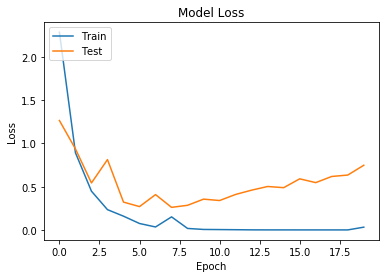

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

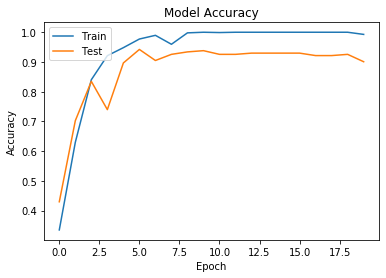

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Save model

In [22]:
model.save_weights('./weights_rot_identify_4.h5')

In [23]:
model_json = model.to_json()
with open("model_rot_identify_4.json", "w") as json_file:
    json_file.write(model_json)

## Predict

In [40]:
# Predict bounding boxes on the test images.
pred_y = model.predict(X_test)
print(pred_y[0])

# find the highest probability class
y_pred = np.zeros((pred_y.shape[0],4))
for i,pred in enumerate(pred_y):
    y_pred[i][np.argmax(pred)] = 1.
print(y_pred[0])

[1.9573835e-12 9.9999332e-01 8.4721128e-09 6.7331571e-06]
[0. 1. 0. 0.]


In [88]:
# convert vectors to classes with dictionary
key_list = list(classes.keys())
val_list = list(classes.values())

labels_pred = [key_list[val_list.index(ys)] for ys in np.argmax(y_pred,axis=1)]

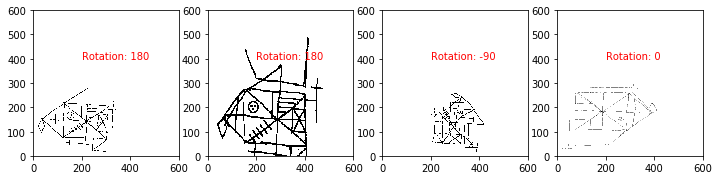

In [90]:
plt.figure(figsize=(12,3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(X_test))
    B = X_test[i]
    B = np.repeat(B[...],3,-1) # convert to three dimensional
    plt.imshow(B, cmap='gray', interpolation='none', origin='lower', extent=[0,img_w,0,img_h])
    plt.annotate('Rotation: {}'.format(labels_pred[i]), (200,400), color='r')

### Total accuracy

In [51]:
print('Final accuracy: {0:0.2f} %'.format(history.history['val_accuracy'][-1]*100))

Final accuracy: 90.08 %


## Rotate images

In [ ]:
from skimage.transform import rotate
def rotate_img(num):
    img = X_test[num]
    img = np.repeat(img[...],3,-1) # convert to three dimensional
    angle = y_test[num]
    
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray'), plt.show()
    plt.subplot(1,2,2)
    new_img = rotate(img, angle, resize=False, center=None, order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    plt.imshow(new_img, cmap='gray'), plt.show()
    
rotate_img(31)